In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Customer Details/ecommerce_customer_data_custom_ratios.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Customer Details/ecommerce_customer_data_large.csv')

In [3]:
df.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,46251,2020-09-08 09:38:32,Electronics,12,3,740,Credit Card,37,0.0,Christine Hernandez,37,Male,0
1,46251,2022-03-05 12:56:35,Home,468,4,2739,PayPal,37,0.0,Christine Hernandez,37,Male,0
2,46251,2022-05-23 18:18:01,Home,288,2,3196,PayPal,37,0.0,Christine Hernandez,37,Male,0
3,46251,2020-11-12 13:13:29,Clothing,196,1,3509,PayPal,37,0.0,Christine Hernandez,37,Male,0
4,13593,2020-11-27 17:55:11,Home,449,1,3452,Credit Card,49,0.0,James Grant,49,Female,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Customer ID            250000 non-null  int64  
 1   Purchase Date          250000 non-null  object 
 2   Product Category       250000 non-null  object 
 3   Product Price          250000 non-null  int64  
 4   Quantity               250000 non-null  int64  
 5   Total Purchase Amount  250000 non-null  int64  
 6   Payment Method         250000 non-null  object 
 7   Customer Age           250000 non-null  int64  
 8   Returns                202404 non-null  float64
 9   Customer Name          250000 non-null  object 
 10  Age                    250000 non-null  int64  
 11  Gender                 250000 non-null  object 
 12  Churn                  250000 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 24.8+ MB


In [5]:
print(df.isnull().sum())

Customer ID                  0
Purchase Date                0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Customer Age                 0
Returns                  47596
Customer Name                0
Age                          0
Gender                       0
Churn                        0
dtype: int64


In [6]:
df['Returns'].fillna(inplace=True, value=0)

In [7]:
print(df.isnull().sum())

Customer ID              0
Purchase Date            0
Product Category         0
Product Price            0
Quantity                 0
Total Purchase Amount    0
Payment Method           0
Customer Age             0
Returns                  0
Customer Name            0
Age                      0
Gender                   0
Churn                    0
dtype: int64


In [8]:
print(df.duplicated().sum())

0


In [9]:
df.columns = df.columns.str.strip()

In [10]:
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])
#Calculating Recency (Days since last purchase) per customer
df['Recency'] = (df['Purchase Date'].max() - df['Purchase Date']).dt.days
#Calculating the total spend per customer
Customer_total_spend = df.groupby('Customer ID')['Total Purchase Amount'].sum().reset_index()
Customer_total_spend.columns = ['Customer ID', 'Total Spend']
#Calculating Transaction frequency per customer
transaction_frequency = df.groupby('Customer ID').size().reset_index(name='Transaction Frequency')
#merging the new features into the data frame
df = pd.merge(df, Customer_total_spend, on='Customer ID', how='left')
df = df.merge(transaction_frequency, on = 'Customer ID', how = 'left')

In [11]:
df.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn,Recency,Total Spend,Transaction Frequency
0,46251,2020-09-08 09:38:32,Electronics,12,3,740,Credit Card,37,0.0,Christine Hernandez,37,Male,0,1102,10184,4
1,46251,2022-03-05 12:56:35,Home,468,4,2739,PayPal,37,0.0,Christine Hernandez,37,Male,0,558,10184,4
2,46251,2022-05-23 18:18:01,Home,288,2,3196,PayPal,37,0.0,Christine Hernandez,37,Male,0,479,10184,4
3,46251,2020-11-12 13:13:29,Clothing,196,1,3509,PayPal,37,0.0,Christine Hernandez,37,Male,0,1036,10184,4
4,13593,2020-11-27 17:55:11,Home,449,1,3452,Credit Card,49,0.0,James Grant,49,Female,1,1021,12223,5


# Visualization Customer Demography

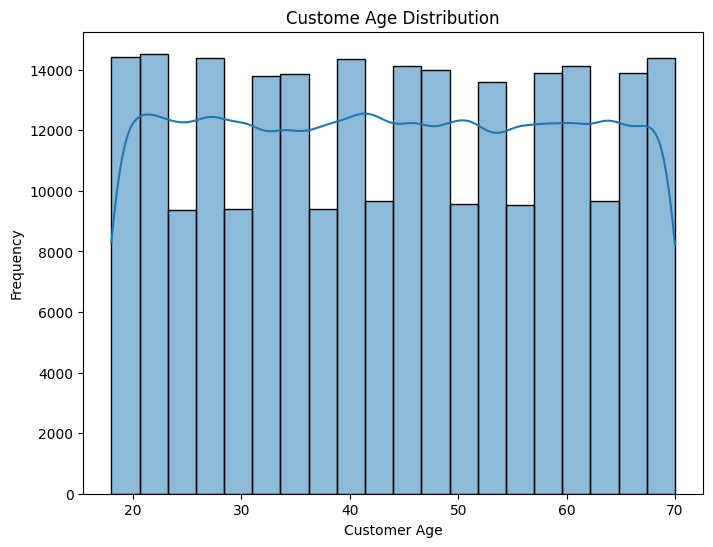

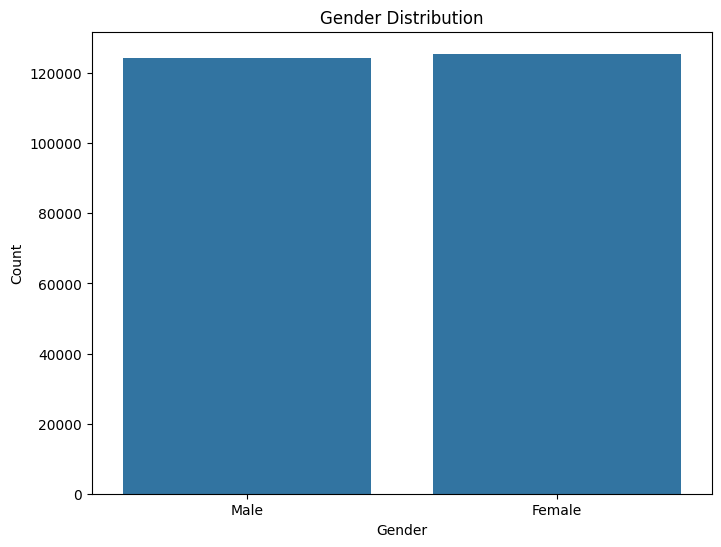

In [12]:
#Customer Age Distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['Customer Age'], bins=20, kde=True)
plt.title('Custome Age Distribution')
plt.xlabel('Customer Age')
plt.ylabel('Frequency')
plt.show()

#Gender Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', data=df)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Analyzing Purchasing Behaviour

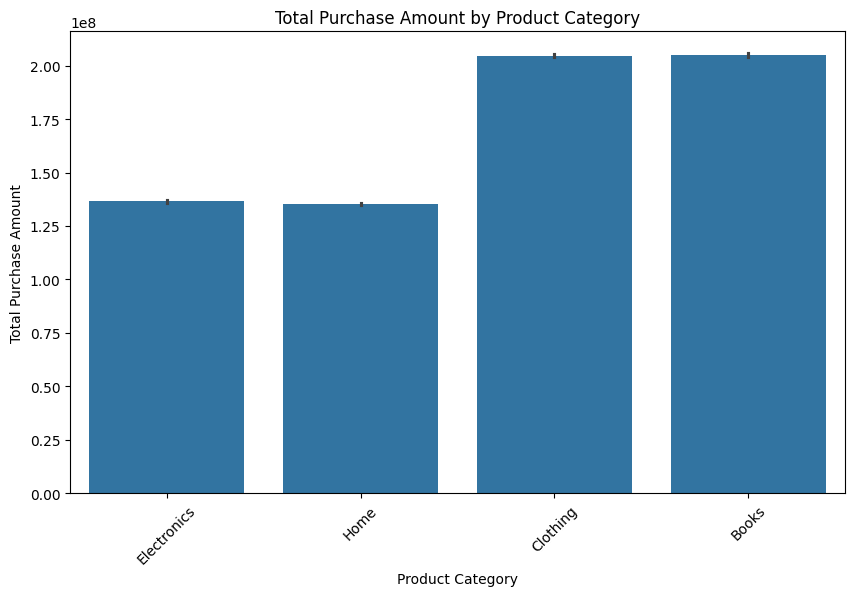

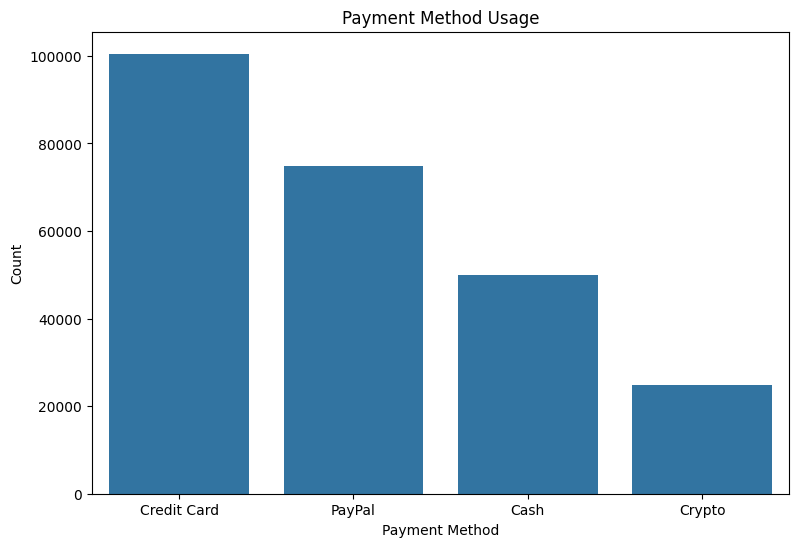

In [13]:
# Total Purchase Amount BY Product Category
plt.figure(figsize=(10, 6))
sns.barplot(x='Product Category', y='Total Purchase Amount', data=df, estimator = sum)
plt.title('Total Purchase Amount by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Purchase Amount')
plt.xticks(rotation=45)
plt.show()

# Payment Method Usage
plt.figure(figsize=(9,6))
sns.countplot(x='Payment Method', data=df)
plt.title('Payment Method Usage')
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.show()

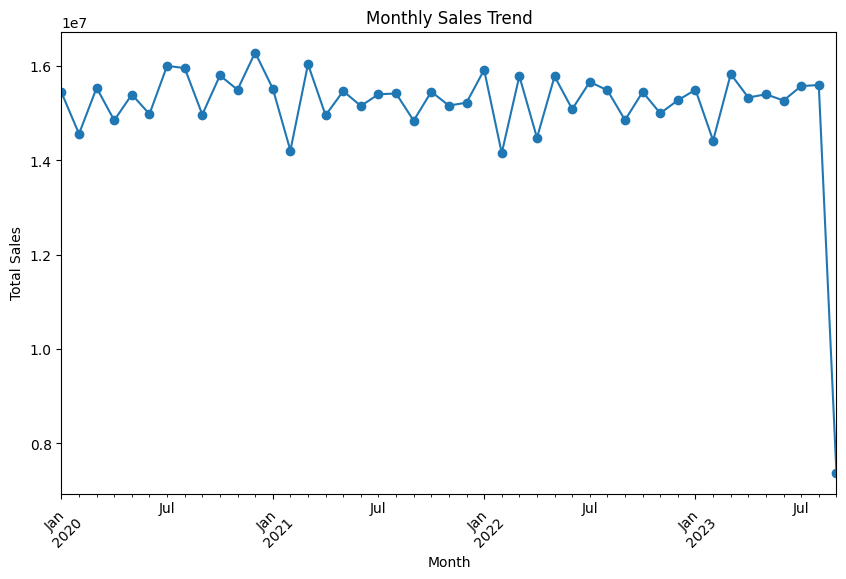

In [14]:
# Time Based Purchase Analysis
df['Month'] = df['Purchase Date'].dt.to_period('M')
monthly_sales = df.groupby('Month')['Total Purchase Amount'].sum()
plt.figure(figsize=(10,6))
monthly_sales.plot(kind='line', marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

In [15]:
# Defining the parameter grid for tuning
param_grid = {
    'classifier__n_estimators' : [100, 200],  # Number of trees in forest
    'classifier__max_depth' : [None, 10, 20],  # Maximum Depth of the tree
    'classifier__min_samples_split' : [2, 5],  # Maximum number of samples required to split a node
    'classifier__min_samples_leaf' : [1, 2],    # Minimum number of samples requiered at each leaf node
    'classifier__bootstrap' : [True, False]        # Whether bootstrap samples are used
}
# Churn Prediction
X = df[['Customer Age', 'Total Spend', 'Transaction Frequency', 'Returns', 'Product Category', 'Payment Method']]
y = df['Churn']

# Preprocessing: One-hot encoding categorical features and scaling numerical features
categorical_features = ['Product Category', 'Payment Method']
numerical_features = ['Customer Age', 'Total Spend', 'Transaction Frequency', 'Returns']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)


# Random Forest pipeline
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', RandomForestClassifier())])

# Initializing GridSearchCV with the RandomForestClassifier and param grid
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs= -1, verbose= 2)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(f"Best Parameters: {best_params}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'classifier__bootstrap': False, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


In [17]:
# using the best model to make predictions
y_pred = grid_search.predict(X_test)

# evaluating the model
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)})")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Getting the ROC-AUC Score for the tuned model
y_proba = grid_search.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc}")

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     40016
           1       0.95      0.00      0.00      9984

    accuracy                           0.80     50000
   macro avg       0.88      0.50      0.45     50000
weighted avg       0.83      0.80      0.71     50000

Confusion Matrix:
[[40015     1]
 [ 9965    19]])
Accuracy: 0.80068
ROC-AUC Score: 0.5479993887360921


# Customer Segmentation using Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


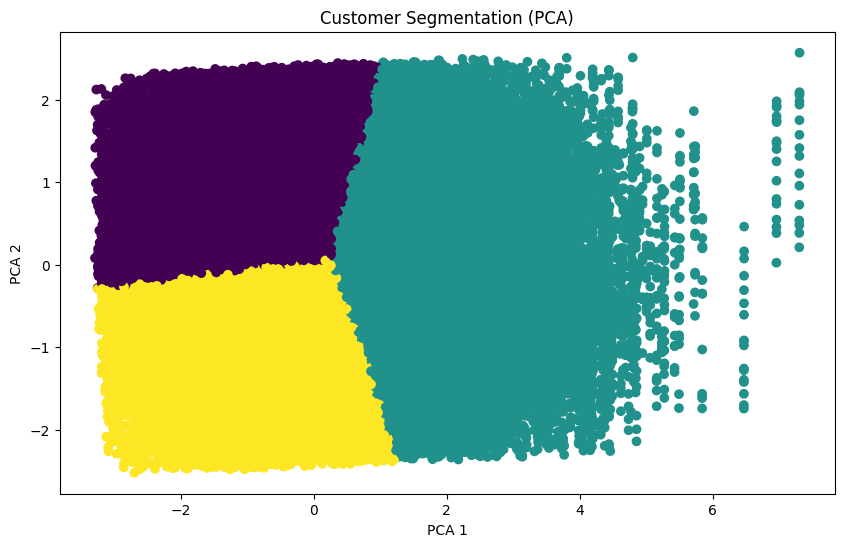

In [18]:
# K-Means Clustering
clustering_features = df[['Total Spend', 'Transaction Frequency', 'Customer Age', 'Recency', ]]

# Normalizing the features
scaler = StandardScaler()
clustering_features_scaled = scaler.fit_transform(clustering_features)

# Reduce dimention with PCA for visualization
pca = PCA(n_components=2)
clustering_features_pca = pca.fit_transform(clustering_features_scaled)

# k-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(clustering_features_pca)

# Plot clusters
plt.figure(figsize=(10, 6))
plt.scatter(clustering_features_pca[:, 0], clustering_features_pca[:, 1], c=df['Cluster'], cmap='viridis')
plt.title('Customer Segmentation (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


# Customer LifeTimeValue(CLV) Prediction

In [19]:
# Features and target for CLV prediction
X_clv = df[['Customer Age', 'Transaction Frequency', 'Recency']]
y_clv = df['Total Spend']

# Split the data
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=42)

# Train a regression model (Linear Regression)
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

# Train the model
lr.fit(X_train_clv, y_train_clv)

# Make predictions and evaluate
y_pred_clv = lr.predict(X_test_clv)
print('R-squared:', lr.score(X_test_clv, y_test_clv))

R-squared: 0.7490087057620641
